In [ ]:
# This cell is for uploading data files.
from google.colab import files
uploaded = files.upload()

Saving apache_logs.txt to apache_logs (1).txt


###1. Data Preparation
Parse Data

In [ ]:
# This cell demonstrates how the  use of parse_str function on a sample string.

from datetime import datetime
import pytz
#%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-agent}i\"
def parse_str(x):
    """
    Returns the string delimited by two characters.
    Example:
        `>>> parse_str('[my string]')`
        `'my string'`
    """
    if x is None:
        return '-'
    return x[1:-1]

In [ ]:
# This cell defines a function to parse integers from the log data, converting strings to integers or returning 0 in case of an error or null value.

parse_str('[my string]')

'my string'

In [ ]:
# This cell demonstrates how to use the parse_int function on a sample string representing an integer.

def parse_int(x):
    """Returns parsed string if no error occured during parse else returns 0"""
    if x is None:
        return 0
    try:
        y = int(x)
        return y
    except ValueError:
        return 0

In [ ]:
# This cell defines a function to parse datetime objects from log entries. This is crucial for sessionization analysis, as it allows for the tracking of user activity over time.

test_ = "234"
parse_int(test_)

234

In [ ]:
# This cell demonstrates the use of parse_datetime function on a sample datetime string.

def parse_datetime(x):
    try:
        dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
        dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
        return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))
    except ValueError:
        return '-'


In [ ]:
# This cell sets up the dataframe, specifying custom parsers for the log data. This is a key step in preparing the data for analysis, ensuring that timestamps, requests, and status codes are correctly interpreted.

parse_datetime('13/Nov/2015:11:45:42 +0000')

datetime.datetime(2015, 11, 3, 11, 45, 4, tzinfo=<UTC>)

## Read data from apache log file

In [ ]:
# This cell aggregates visit counts by IP address and device, preparing data for identifying frequent visitors by counting the number of times each visitor appears in the log.

import re
import pandas as pd
conv = {'time': parse_datetime,
        'request': parse_str,
        'status': parse_int,
        'size': parse_int,
        'referer': parse_str,
        'user_agent': parse_str}

data = pd.read_csv('./apache_logs.txt',
                    header=None,
                    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                    engine='python',
                    na_values='-',
                    usecols=[0, 3, 4, 5, 6, 7, 8],
                    #names=['ip', 'time', 'request', 'status', 'size', 'referer', 'user_agent'],
                    names=['Client_IP_address', 'Time_of_activity','Requested_Page', 'Status_Code', 'Size_of_Page', 'Referer_page','Client_Device'],
                    converters=conv,on_bad_lines='skip')
data.head(4)

,Client_IP_address,Time_of_activity,Requested_Page,Status_Code,Size_of_Page,Referer_page,Client_Device
0,83.149.9.216,[17/May/2015:10:05:03 +0000],"""GET /presentations/logstash-monitorama-2013/i...",200,203023.0,"""http://semicomplete.com/presentations/logstas...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1..."
1,83.149.9.216,[17/May/2015:10:05:43 +0000],"""GET /presentations/logstash-monitorama-2013/i...",200,171717.0,"""http://semicomplete.com/presentations/logstas...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1..."
2,83.149.9.216,[17/May/2015:10:05:47 +0000],"""GET /presentations/logstash-monitorama-2013/p...",200,26185.0,"""http://semicomplete.com/presentations/logstas...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1..."
3,83.149.9.216,[17/May/2015:10:05:12 +0000],"""GET /presentations/logstash-monitorama-2013/p...",200,7697.0,"""http://semicomplete.com/presentations/logstas...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1..."


In [ ]:
# This cell identifies the top 10 frequent visitors based on the aggregated visit counts and prints their information. This directly addresses the task of finding frequent visitors.

# counting unique values from IP and Devices
IP=set(data['Client_IP_address'])
print(len(IP))
devices=set(data['Client_Device'])
print(len(devices))

1754
559


## 2. Identifying 10 Frequent Visitors

This cell is iterating over the pandas DataFrame named data, which presumably contains web visitation or event data with at least two columns: 'Client_IP_address' and 'Client_Device'. The purpose of the code is to count the number of occurrences (visits or events) for each unique combination of client IP address and client device.

###Breakdown :

- It initializes an empty dictionary D.
- It then iterates through each row of the DataFrame data using iterrows(), which provides the index (i) and the data (row) for each row.
- For each row, it checks if the combination of 'Client_IP_address' and 'Client_Device' exists as a tuple key in the dictionary D.
- If the key exists, it increments the value associated with that key by 1.

This increment signifies another occurrence of that specific IP-device combination.
If the key does not exist, it adds the tuple of 'Client_IP_address' and 'Client_Device' as a new key to the dictionary D and sets its value to 1, indicating the first occurrence of this unique combination.

In [ ]:
# Prints the first 5 timestamps from the sessionization analysis.

D={}
for i,row in data.iterrows():
    if(tuple((row['Client_IP_address'],row['Client_Device'])) in D):
        D[tuple((row['Client_IP_address'],row['Client_Device']))]+=1

    else:
        D[tuple((row['Client_IP_address'],row['Client_Device']))]=1

This cell below sorts the dictionary D based on the values (the counts of unique combinations of IP addresses and client devices) in descending order and then selects the top 10 most frequent combinations.

In [ ]:
# 10 Frequent visitors

freq = sorted(D, key = D.get, reverse = True)


top_10 = freq[:10]
for i,j in enumerate(top_10, start=1):
    print(i,"",j)

1  ('46.105.14.53', '"UniversalFeedParser/4.2-pre-314-svn +http://feedparser.org/"')
2  ('130.237.218.86', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.91 Safari/537.36"')
3  ('75.97.9.59', '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36"')
4  ('66.249.73.135', '"Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5376e Safari/8536.25 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"')
5  ('66.249.73.135', '"Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"')
6  ('50.16.19.13', '"Tiny Tiny RSS/1.11 (http://tt-rss.org/)"')
7  ('68.180.224.225', '"Mozilla/5.0 (compatible; Yahoo! Slurp; http://help.yahoo.com/help/us/ysearch/slurp)"')
8  ('208.115.111.72', '"Mozilla/5.0 (compatible; Ezooms/1.0; help@moz.com)"')
9  ('198.46.149.143', '"Tiny Tiny RSS/1.11 (http://tt-rss.or

Here are the results of the top 10 users who visited frequently.

## Sessions and page views per session

The cell below creates three lists (time, page, and al) based on the first 500 unique combinations of IP addresses and client devices stored in the dictionary D.

In [ ]:
# This cell applies the Apriori algorithm to identify frequent itemsets among the pages visited. The settings for support, confidence, and lift can be adjusted to refine the results.

time=[]
page=[]
al=[]
for i in list(D)[:500]:
    for j,row in data.iterrows():
        if(i==tuple((row['Client_IP_address'],row['Client_Device']))):
            time.append(row['Time_of_activity'])
            page.append(row['Requested_Page'])
            al.append(i)


In [ ]:
# A demonstration of accessing the head of a dataframe, possibly for a quick data inspection or to display the initial rows of sessionized data.

al[:5]

[('83.149.9.216',
  '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'),
 ('83.149.9.216',
  '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'),
 ('83.149.9.216',
  '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'),
 ('83.149.9.216',
  '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"'),
 ('83.149.9.216',
  '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"')]

In [ ]:
# This cell attempts to filter and display pages with a support ratio greater than 20%.

time[:5]

['[17/May/2015:10:05:03 +0000]',
 '[17/May/2015:10:05:43 +0000]',
 '[17/May/2015:10:05:47 +0000]',
 '[17/May/2015:10:05:12 +0000]',
 '[17/May/2015:10:05:07 +0000]']

In [ ]:
# A cell intended to display results related to association rule mining or filtering based on support values.

page[:5]

['"GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1"',
 '"GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1"',
 '"GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1"',
 '"GET /presentations/logstash-monitorama-2013/plugin/zoom-js/zoom.js HTTP/1.1"',
 '"GET /presentations/logstash-monitorama-2013/plugin/notes/notes.js HTTP/1.1"']

In [ ]:
# Installs the gsppy package, necessary for executing the GSP (Generalized Sequential Pattern) algorithm for sequential pattern mining.

df=pd.DataFrame({'Time':time,'Pages':page,'Client':al})
df.head(40)

,Time,Pages,Client
0,[17/May/2015:10:05:03 +0000],"""GET /presentations/logstash-monitorama-2013/i...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
1,[17/May/2015:10:05:43 +0000],"""GET /presentations/logstash-monitorama-2013/i...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
2,[17/May/2015:10:05:47 +0000],"""GET /presentations/logstash-monitorama-2013/p...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
3,[17/May/2015:10:05:12 +0000],"""GET /presentations/logstash-monitorama-2013/p...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
4,[17/May/2015:10:05:07 +0000],"""GET /presentations/logstash-monitorama-2013/p...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
5,[17/May/2015:10:05:34 +0000],"""GET /presentations/logstash-monitorama-2013/i...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
6,[17/May/2015:10:05:57 +0000],"""GET /presentations/logstash-monitorama-2013/c...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
7,[17/May/2015:10:05:50 +0000],"""GET /presentations/logstash-monitorama-2013/c...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
8,[17/May/2015:10:05:24 +0000],"""GET /presentations/logstash-monitorama-2013/i...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."
9,[17/May/2015:10:05:50 +0000],"""GET /presentations/logstash-monitorama-2013/i...","(83.149.9.216, ""Mozilla/5.0 (Macintosh; Intel ..."


From the above data frame we can see:

(83.149.9.216, "Mozilla/5.0 (Macintosh; Intel): 22 pageviews


(24.236.252.67, "Mozilla/5.0 (X11) : 1 pageview


(93.114.45.13, "Mozilla/5.0 (X11; Linux x86_64): 6 pageviews


(66.249.73.135, "Mozilla/5.0 (iPhone; CPU): 10 page views

## Top Five most referrer websites



This cell processes a list of URLs from a 'Referer_page' column in a pandas DataFrame named data, aiming to identify and display the top 5 most frequently occurring domains (excluding any potential parsing errors represented by ':///'), including their schemes (e.g., http or https)

In [ ]:
# This cell is intended for clustering users based on navigational patterns, using t-SNE for dimensionality reduction and KMeans for clustering. This aims to visualize clusters of users with similar behavior.

referers = data['Referer_page'].dropna(how='all')
from urllib.parse import urlparse
ref=[]
for i in referers:
    parsed_uri = urlparse(i.replace('"', ''))
    result = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    ref.append(result)
word_counter = {}
for url in ref:
    if url in word_counter:
        word_counter[url] += 1
    else:
        word_counter[url] = 1
popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_5 = popular_words[:6]
for i in top_5:
    if(i==':///'''):
        top_5.remove(i)
for i,j in enumerate(top_5,start=1):
    print(i,"",j)

1  http://www.semicomplete.com/
2  http://semicomplete.com/
3  http://www.google.com/
4  https://www.google.com/
5  http://stackoverflow.com/


## Ten most frequent patterns

The code below is organizing the pages visited by different clients during their sessions.


Here's a breakdown of what each part of the code does:

1. `Pages_visited_per_session = list(df['Pages'])`: Extracts the column 'Pages' from the DataFrame `df` and converts it into a list named `Pages_visited_per_session`. This list likely contains the pages visited by clients during their sessions.

2. `Pages_accessed = {}`: Initializes an empty dictionary to store pages accessed by each client.

3. Iterating over rows and populating `Pages_accessed`:
   - The code iterates over each row in the DataFrame `df`.
   - For each row, it checks if the client's ID (`row['Client']`) is already in the `Pages_accessed` dictionary.
   - If the client ID is present, it appends the page visited (`row['Pages']`) to the list of pages accessed by that client.
   - If the client ID is not present, it creates a new key-value pair where the key is the client ID and the value is a list containing the page visited.

4. Printing pages accessed by each client:
   - After populating `Pages_accessed`, the code iterates over the dictionary.
   - For each client, it prints a message indicating the client's ID and the pages accessed by that client.

5. `all_pages=[]`: Initializes an empty list to store all pages accessed by all clients.

6. Collecting all pages accessed:
   - The code iterates over each client in `Pages_accessed`.
   - For each client, it appends the list of pages accessed by that client to the `all_pages` list.

Then returns us a dictionary `Pages_accessed` where each key represents a client ID, and the corresponding value is a list of pages accessed by that client. Additionally, you'll have a list `all_pages` containing all pages accessed by all clients.

In [ ]:
Pages_visited_per_session=list(df['Pages'])
Pages_accessed={}
for i,row in df.iterrows():
    if(row['Client'] in Pages_accessed):
        Pages_accessed[row['Client']].append(row['Pages'])
    else:
        Pages_accessed[row['Client']]=[row['Pages']]
for i in Pages_accessed:
    print('\n Client {} accessed these pages \n {} \n'.format(i,Pages_accessed[i]))
all_pages=[]
for i in Pages_accessed:
    all_pages.append(Pages_accessed[i])


 Client ('83.149.9.216', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"') accessed these pages 
 ['"GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/plugin/zoom-js/zoom.js HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/plugin/notes/notes.js HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/images/sad-medic.png HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/css/fonts/Roboto-Bold.ttf HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/css/fonts/Roboto-Regular.ttf HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/images/frontend-response-codes.png HTTP/1.1"', '"GET /presentations/logstash-monitorama-2013/images/kibana-das

In [ ]:
!pip install apyori


 Client ('180.76.5.22', '"Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)"') accessed these pages 
 ['"GET /misc/funkyoutput HTTP/1.1"', '"GET /misc/practical-shoutcast-server.html HTTP/1.1"'] 


 Client ('123.125.71.116', '"Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)"') accessed these pages 
 ['"GET / HTTP/1.1"'] 


 Client ('68.193.198.76', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:27.0) Gecko/20100101 Firefox/27.0"') accessed these pages 
 ['"GET /favicon.ico HTTP/1.1"'] 


 Client ('194.94.204.181', '"Mozilla/5.0 (Windows NT 6.3; WOW64; rv:27.0) Gecko/20100101 Firefox/27.0"') accessed these pages 
 ['"GET /projects/xdotool/xdotool.xhtml HTTP/1.1"', '"GET /favicon.ico HTTP/1.1"'] 


 Client ('70.190.77.28', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36"') accessed these pages 
 ['"GET /presentations/puppet-at-loggly/puppet-

### Performing association rule mining with the Apriori algorithm

In [ ]:
from apyori import apriori
association_rules = apriori(all_pages, min_support=0.1, min_confidence=0.5, min_lift=1, min_length=7)
association_results = list(association_rules)
support=[]
items=[]
rhs=[]
lhs=[]
con=[]
lift=[]
for i in association_results:
    support.append(i.support)
    items.append(i.items)
    rhs.append(i.ordered_statistics[0][1])
    lhs.append(i.ordered_statistics[0][0])
    con.append(i.ordered_statistics[0][2])
    lift.append(i.ordered_statistics[0][3])
df=pd.DataFrame({'Items':items,'Antecedent':lhs,'Precedent':rhs,'Support':support,'Confidence':con,'Lift':lift})

In [ ]:
df.head()

,Items,Antecedent,Precedent,Support,Confidence,Lift
0,"(""GET /favicon.ico HTTP/1.1"", ""GET /images/jor...","(""GET /favicon.ico HTTP/1.1"")","(""GET /images/jordan-80.png HTTP/1.1"")",0.180,0.580645,2.592166
1,"(""GET /favicon.ico HTTP/1.1"", ""GET /images/web...","(""GET /favicon.ico HTTP/1.1"")","(""GET /images/web/2009/banner.png HTTP/1.1"")",0.180,0.580645,2.639296
2,"(""GET /favicon.ico HTTP/1.1"", ""GET /reset.css ...","(""GET /favicon.ico HTTP/1.1"")","(""GET /reset.css HTTP/1.1"")",0.180,0.580645,2.524544
3,"(""GET /favicon.ico HTTP/1.1"", ""GET /style2.css...","(""GET /favicon.ico HTTP/1.1"")","(""GET /style2.css HTTP/1.1"")",0.180,0.580645,2.502781
4,"(""GET /images/jordan-80.png HTTP/1.1"", ""GET /i...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /images/web/2009/banner.png HTTP/1.1"")",0.216,0.964286,4.383117


The dataframe we have above contains information about the association rules mined from the pages accessed by clients, including the support (frequency), confidence, and lift for each rule. This information can be further analyzed and interpreted to gain insights into the browsing patterns and behaviors of clients on the website.

## Extracting meaningful association rules


This loop iterates over each row in the filtered DataFrame s_p, where rules with support greater than 0.20 are considered. It prints the antecedent, precedent, support, confidence, and lift for each association rule meeting the support threshold

In [ ]:
s_p=df[df['Support']>0.20].sort_values('Support',ascending=False)
for i,items in df.iterrows():
    # first index of the inner list
    # Contains base item and add item
#     pair = item[0]
#     items = [x for x in pair]
#     print(item[0])
    print("Rule: " + str(items['Antecedent']) + " -> " + str(items['Precedent']))
    #second index of the inner list
    print("Support: " + str(items['Support']))
    #third index of the list located at 0th
    #of the third index of the inner list
    print("Confidence: " + str(items['Confidence']))
    print("Lift: " + str(items['Lift']))
    print("=====================================")

Rule: frozenset({'"GET /favicon.ico HTTP/1.1"'}) -> frozenset({'"GET /images/jordan-80.png HTTP/1.1"'})
Support: 0.18
Confidence: 0.5806451612903225
Lift: 2.592165898617511
Rule: frozenset({'"GET /favicon.ico HTTP/1.1"'}) -> frozenset({'"GET /images/web/2009/banner.png HTTP/1.1"'})
Support: 0.18
Confidence: 0.5806451612903225
Lift: 2.6392961876832843
Rule: frozenset({'"GET /favicon.ico HTTP/1.1"'}) -> frozenset({'"GET /reset.css HTTP/1.1"'})
Support: 0.18
Confidence: 0.5806451612903225
Lift: 2.5245441795231414
Rule: frozenset({'"GET /favicon.ico HTTP/1.1"'}) -> frozenset({'"GET /style2.css HTTP/1.1"'})
Support: 0.18
Confidence: 0.5806451612903225
Lift: 2.5027808676307
Rule: frozenset({'"GET /images/jordan-80.png HTTP/1.1"'}) -> frozenset({'"GET /images/web/2009/banner.png HTTP/1.1"'})
Support: 0.216
Confidence: 0.9642857142857143
Lift: 4.383116883116883
Rule: frozenset({'"GET /images/jordan-80.png HTTP/1.1"'}) -> frozenset({'"GET /reset.css HTTP/1.1"'})
Support: 0.214
Confidence: 0.955

In [ ]:
s_p

,Items,Antecedent,Precedent,Support,Confidence,Lift
9,"(""GET /reset.css HTTP/1.1"", ""GET /style2.css H...","(""GET /reset.css HTTP/1.1"")","(""GET /style2.css HTTP/1.1"")",0.226,0.982609,4.235382
4,"(""GET /images/jordan-80.png HTTP/1.1"", ""GET /i...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /images/web/2009/banner.png HTTP/1.1"")",0.216,0.964286,4.383117
5,"(""GET /images/jordan-80.png HTTP/1.1"", ""GET /r...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /reset.css HTTP/1.1"")",0.214,0.955357,4.153727
6,"(""GET /images/jordan-80.png HTTP/1.1"", ""GET /s...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /style2.css HTTP/1.1"")",0.214,0.955357,4.117919
18,"(""GET /images/jordan-80.png HTTP/1.1"", ""GET /r...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /reset.css HTTP/1.1"", ""GET /style2.css H...",0.214,0.955357,4.227244
7,"(""GET /reset.css HTTP/1.1"", ""GET /images/web/2...","(""GET /images/web/2009/banner.png HTTP/1.1"")","(""GET /reset.css HTTP/1.1"")",0.212,0.963636,4.189723
8,"(""GET /images/web/2009/banner.png HTTP/1.1"", ""...","(""GET /images/web/2009/banner.png HTTP/1.1"")","(""GET /style2.css HTTP/1.1"")",0.212,0.963636,4.153605
16,"(""GET /reset.css HTTP/1.1"", ""GET /images/jorda...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /images/web/2009/banner.png HTTP/1.1"", ""...",0.212,0.946429,4.464286
17,"(""GET /images/jordan-80.png HTTP/1.1"", ""GET /i...","(""GET /images/jordan-80.png HTTP/1.1"")","(""GET /images/web/2009/banner.png HTTP/1.1"", ""...",0.212,0.946429,4.464286
19,"(""GET /reset.css HTTP/1.1"", ""GET /images/web/2...","(""GET /images/web/2009/banner.png HTTP/1.1"")","(""GET /reset.css HTTP/1.1"", ""GET /style2.css H...",0.212,0.963636,4.263878


## Install Generalized Sequential Patterns Algorithm

Sequential Pattern Mining Using GSP Algorithm

In [ ]:
!pip install gsppy

In [ ]:
import argparse
import logging
import random
from gsppy.gsp import GSP
logging.basicConfig(level=logging.DEBUG)

The GSP algorithm will analyze the sequences of pages accessed by clients and identify frequent sequential patterns that occur with a support greater than or equal to the specified threshold (0.1 in this case). The result will contain these sequential patterns along with their support values

In [ ]:
transactions=all_pages
result = GSP(transactions).search(0.1)

In [ ]:
result

[{('"GET /favicon.ico HTTP/1.1"',): 155,
  ('"GET /reset.css HTTP/1.1"',): 115,
  ('"GET /style2.css HTTP/1.1"',): 116,
  ('"GET /images/jordan-80.png HTTP/1.1"',): 112,
  ('"GET /images/web/2009/banner.png HTTP/1.1"',): 110},
 {('"GET /images/jordan-80.png HTTP/1.1"',
   '"GET /images/web/2009/banner.png HTTP/1.1"'): 94,
  ('"GET /images/web/2009/banner.png HTTP/1.1"',
   '"GET /favicon.ico HTTP/1.1"'): 54,
  ('"GET /reset.css HTTP/1.1"', '"GET /style2.css HTTP/1.1"'): 98,
  ('"GET /style2.css HTTP/1.1"', '"GET /images/jordan-80.png HTTP/1.1"'): 69},
 {('"GET /reset.css HTTP/1.1"',
   '"GET /style2.css HTTP/1.1"',
   '"GET /images/jordan-80.png HTTP/1.1"'): 65,
  ('"GET /style2.css HTTP/1.1"',
   '"GET /images/jordan-80.png HTTP/1.1"',
   '"GET /images/web/2009/banner.png HTTP/1.1"'): 62},
 {('"GET /reset.css HTTP/1.1"',
   '"GET /style2.css HTTP/1.1"',
   '"GET /images/jordan-80.png HTTP/1.1"',
   '"GET /images/web/2009/banner.png HTTP/1.1"'): 59}]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


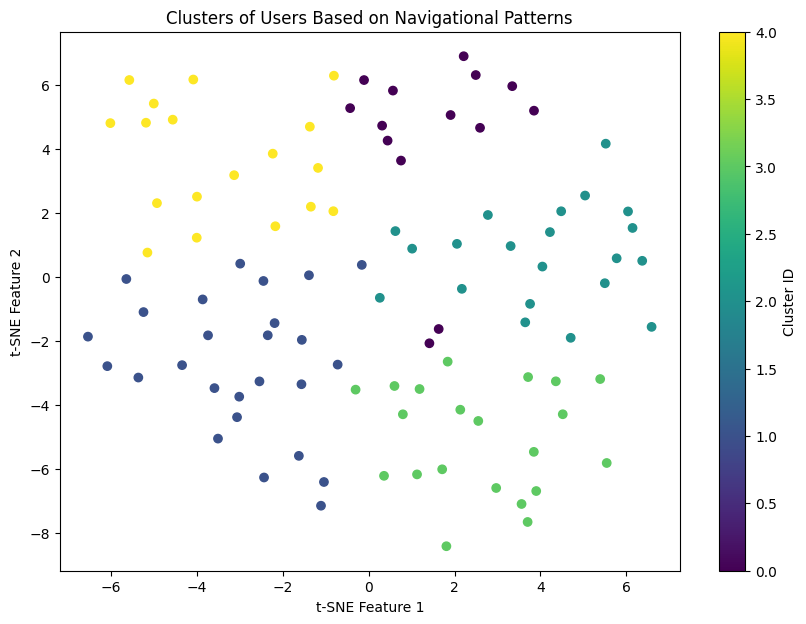

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

# Each row represents a user, each column a feature extracted from navigational patterns
user_navigation_features = np.random.rand(100, 5)  # 100 users, 5 features for demonstration

# Clustering (using KMeans)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(user_navigation_features)

# Dimensionality Reduction with t-SNE for Visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(user_navigation_features)

# Visualization
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Clusters of Users Based on Navigational Patterns')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster ID')
plt.show()